# Long-range CNOT gate teleportation using dynamic circuits

In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.classical import expr

def get_dynaic_CNOT_circuit(num_qubits):


  num_ancilla = num_qubits - 2 
  num_ancilla_pair = int(num_ancilla/2)

  qr = QuantumRegister(num_qubits)
  cr1 = ClassicalRegister(num_ancilla_pair, name='cr1') # The parity controller X gate
  cr2 = ClassicalRegister(num_ancilla - num_ancilla_pair, name='cr2') # The parity controller Z gate
  cr3 = ClassicalRegister(2, name='cr3') # For the fianl measurements on the control and target qubits
  qc = QuantumCircuit(qr, cr1, cr2, cr3)

  # Initialize ther controoo qubit
  qc.h(0)
  qc.barrier()

  # Entangle the control qubit and the first ancilla qubit
  qc.cx(0, 1)

  # Create Bell pairs on aaaaailla qubits 
  # The first ancilla qubit in index 1
  for i in range(num_ancilla_pair):
    qc.h(2+2*i)
    qc.cx(2+2*i, 2+2*i+1)

  # Prepare Bell pairs on staggered ancilla and data qubits
  for i in range(num_ancilla_pair+1):
    qc.cx(1+2*i, 1+2*i+1)
  for i in range(1,num_ancilla_pair+2):
    qc.h(2*i-1)

  # Measurement on alternating ancilla qubits starting with the first one
  # Keep track of the parity for eventual conditional Z gate
  for i in range(1, num_ancilla_pair+2):
    qc.measure(2*i -1 , cr2[i-1])
    if i == 1:
      parity_control = expr.lift(cr2[i-1])
    else:
      parity_control = expr.bit_xor(cr2[i-1], parity_control)

  # Measurement on staggered alternating ancilla qubits starting with the secound one
  # Keep track of the parity for eventual conditional X gate
  for i in range(num_ancilla_pair):
    qc.measure(2*i + 2 , cr1[i])
    if i == 1:
      parity_target = expr.lift(cr1[i])
    else:
      parity_target = expr.bit_xor(cr1[i], parity_control)

  with qc.if_test(parity_control):
    qc.z(0)
  
  with qc.if_test(parity_target):
    qc.x(-1)

  return qc

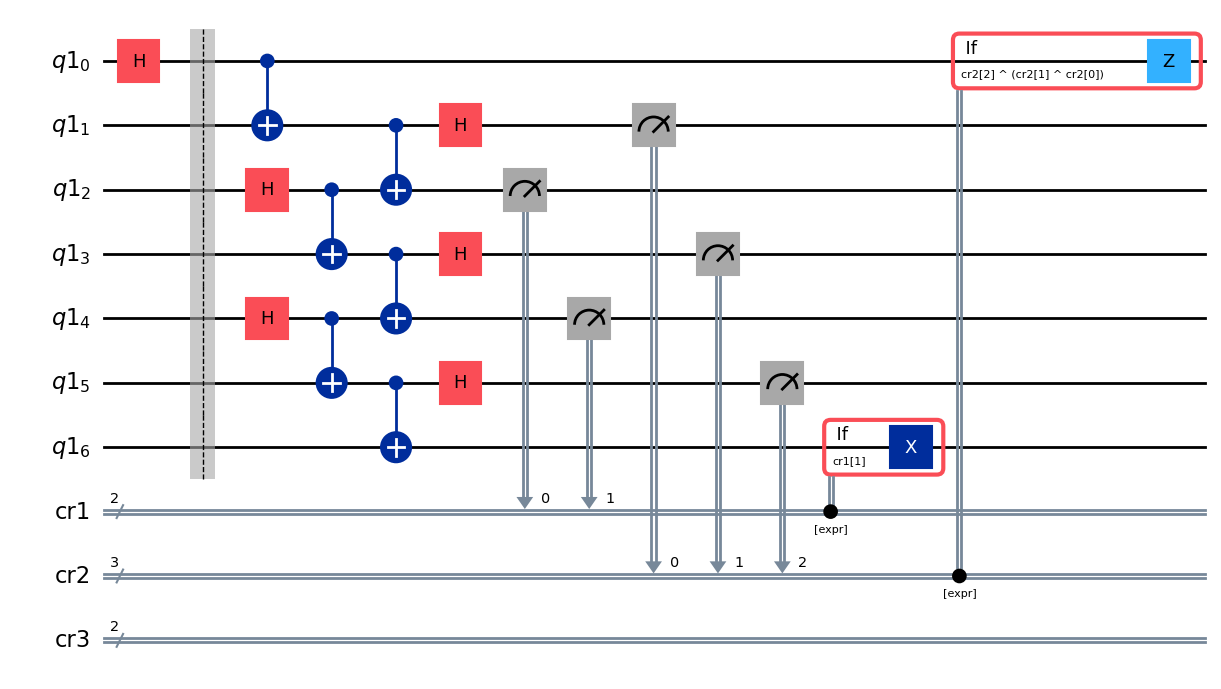

In [3]:
qc = get_dynaic_CNOT_circuit(num_qubits=7)
qc.draw(output='mpl')

In [4]:
max_num_qubit = 41

qc_list = []
num_qubit_list = list(range(7,max_num_qubit+1, 2))
for num_qubit in num_qubit_list:
  qc_list.append(get_dynaic_CNOT_circuit(num_qubit))

# Step 2: Optimize the problem for quantum execution

In [8]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService

backend_name = 'ibm_brisbane'
service = QiskitRuntimeService()
backend = service.backend(backend_name)
pm = generate_preset_pass_manager(optimization_level=1, backend=backend)

qc_transpiled_list = pm.run(qc_list)

# Step 3: Execute the circuit

In [ ]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(backend=backend)
job = sampler.run(qc_transpiled_list)
print(job.job_id())

# Step 4: Post-processing and plotting

In [ ]:
import matplotlib.pyplot as plt
from qiskit_ibm_runtime import QiskitRuntimeService 

job_id = 'ct01e18cqfh00089jecg'

service = QiskitRuntimeService()
job = service.get_job(job_id)
result = job.result()

list_Bell = []
list_other = []
for i in range(len(qc_list)):
  data = result[i+1].data
  counts = data.cr3.get_counts()
  total_counts = data.cr3.num_shots

  prob_Bell = (counts['00'] + counts['11']) / total_counts

  list_Bell.append(prob_Bell)
  list_other.append(1 - prob_Bell)

plt.plot(num_qubit_list, list_Bell, '--o', label='00 or 11')
plt.plot(num_qubit_list, list_other, '--o', label='01 or 10')
plt.xlabel('Number of qubits')
plt.ylabel('Probability')
plt.legend()